<a href="https://colab.research.google.com/github/o-bissing/TF_Udemy/blob/main/RNN_on_a_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('RSCCASN.csv',parse_dates=True,index_col='DATE')

In [6]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [7]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

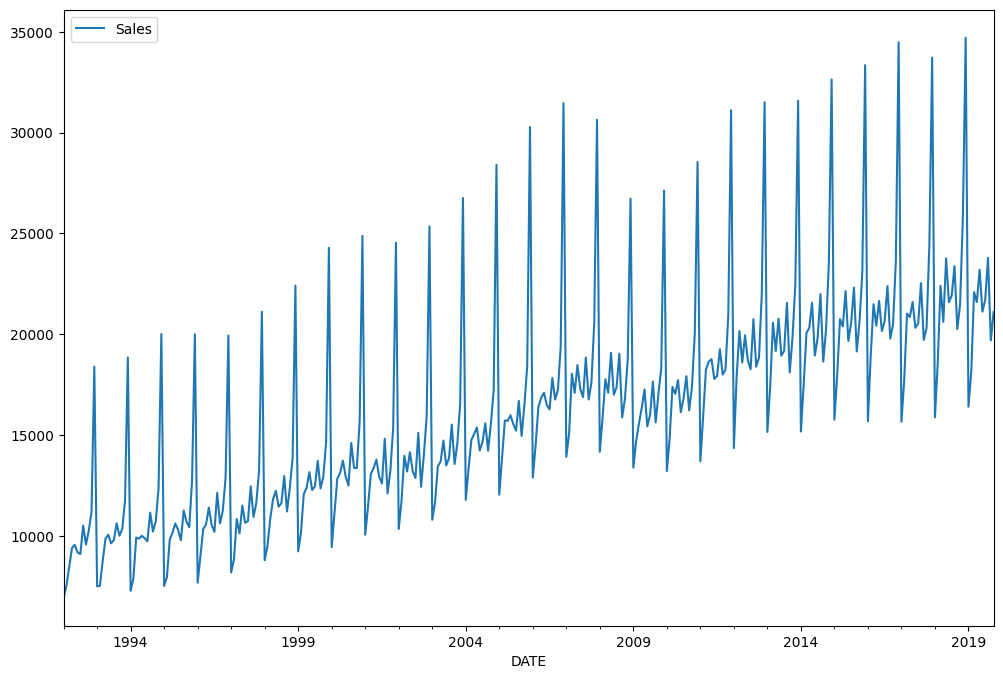

In [8]:
df.plot(figsize=(12,8))

In [9]:
len(df)

334

In [10]:
len(df) - 18

316

In [11]:
test_size = 18
test_ind = len(df) - test_size

In [12]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [13]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [14]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
scaler.fit(train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(train)

In [19]:
scaled_test = scaler.transform(test)

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
len(test)

18

In [22]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,
                                length=length,batch_size=1)

In [23]:
X,y = generator[0]

In [24]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [25]:
y

array([[0.02047633]])

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [27]:
n_features = 1

In [28]:
model = Sequential()
model.add(LSTM(100,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [31]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                           length=length,batch_size=1)

In [32]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

<ipython-input-32-252a26bee3bb>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


Epoch 1/20
304/304 [==============================] - 7s 15ms/step - loss: 0.0227 - val_loss: 0.0029
Epoch 2/20
304/304 [==============================] - 3s 10ms/step - loss: 0.0200 - val_loss: 0.0066
Epoch 3/20
304/304 [==============================] - 3s 10ms/step - loss: 0.0102 - val_loss: 0.0020
Epoch 4/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 5/20
304/304 [==============================] - 3s 10ms/step - loss: 0.0037 - val_loss: 0.0045


In [33]:
losses = pd.DataFrame(model.history.history)

<Axes: >

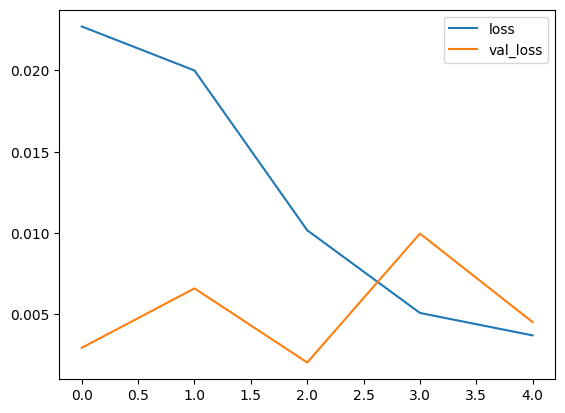

In [34]:
losses.plot()

In [35]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [36]:
true_predictions = scaler.inverse_transform(test_predictions)

In [37]:
test['Predictions'] = true_predictions

<ipython-input-37-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [38]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22651.781851
2018-06-01,21589,21587.088699
2018-07-01,21919,21916.018304
2018-08-01,23381,23768.986388
2018-09-01,20260,21348.457005
2018-10-01,21473,22135.794497
2018-11-01,25831,26382.176815
2018-12-01,34706,37423.501092
2019-01-01,16410,17550.664907


<Axes: xlabel='DATE'>

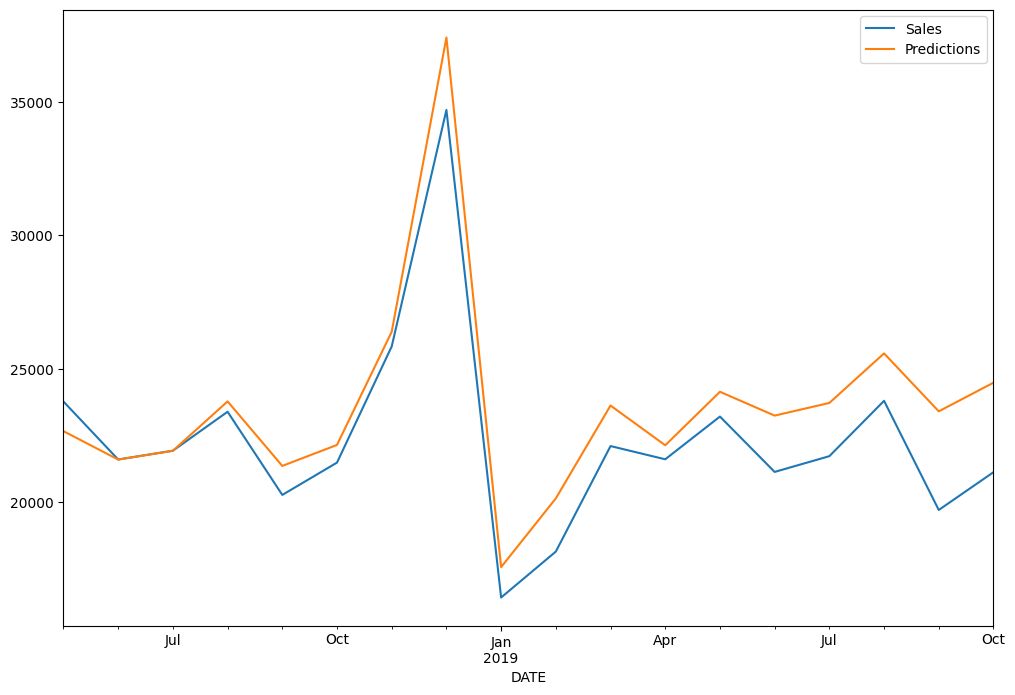

In [39]:
test.plot(figsize=(12,8))

In [40]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [41]:
length = 12
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                                length=length,batch_size=1)

In [51]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model.fit_generator(generator,epochs=8)

Epoch 1/8


<ipython-input-51-150e18c2a8b3>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


322/322 [==============================] - 7s 16ms/step - loss: 0.0224
Epoch 2/8
322/322 [==============================] - 3s 11ms/step - loss: 0.0173
Epoch 3/8
322/322 [==============================] - 5s 16ms/step - loss: 0.0095
Epoch 4/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0046
Epoch 5/8
322/322 [==============================] - 4s 13ms/step - loss: 0.0019
Epoch 6/8
322/322 [==============================] - 5s 17ms/step - loss: 0.0016
Epoch 7/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0020
Epoch 8/8
322/322 [==============================] - 6s 18ms/step - loss: 0.0017


In [52]:
forecast = []
periods = 12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(periods):

  current_pred = model.predict(current_batch)[0]

  forecast.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [53]:
forecast = scaler.inverse_transform(forecast)

In [54]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [55]:
forecast

array([[23525.25049114],
       [22502.85375309],
       [22753.35530281],
       [24545.13535118],
       [22260.25558949],
       [22860.60428524],
       [26515.6429081 ],
       [35949.6591301 ],
       [18949.04217243],
       [21199.0544405 ],
       [24483.23808002],
       [23055.08274651]])

In [56]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,
                               freq="MS")

In [57]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [58]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

<Axes: xlabel='DATE'>

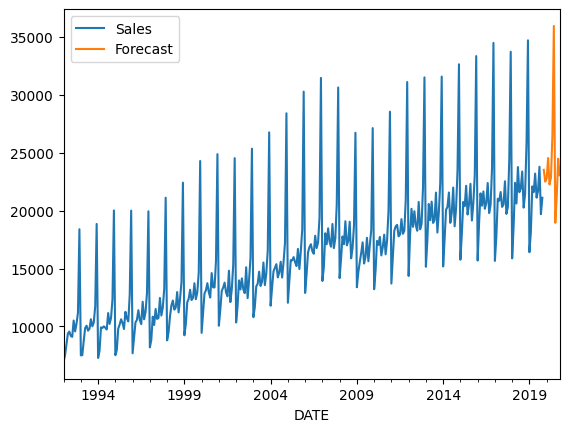

In [59]:
ax = df.plot()
forecast_df.plot(ax=ax)